# Généralisation aux régressions multi-linéaires

Dans le [cahier précédant](./01_regression_lineaire.ipynb) nous avons vu les régression linéaire en dimension 1, qui correspondent aux droites cherchant à approximer un nuage de points.
Rien ne nous empêche de généraliser cette méthode à des espaces de dimensions supérieures. Les formules et les méthodes seront toujours valables.

Or le [premier cahier](./00_concepts.ipynb) de ce répertoire a montré qu'on pouvait ainsi aussi faire des régression polynomiale, ce que nous allons expérimenter maintenant.

## Régression polynomiale

Pour nous entraîner, nous générons une courbe polynomiale autour de laquelle nous introduisons un bruit stochastique. L'objectif sera ensuite de retrouver le polynôme d'origine. Nous en profitons aussi pour utiliser les [polynomes de NumPy](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.html#numpy.polynomial.polynomial.Polynomial) (on pourra regarder le [cahier qui leur est dédié](../02_std_ext/15_polynomial.ipynb)).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

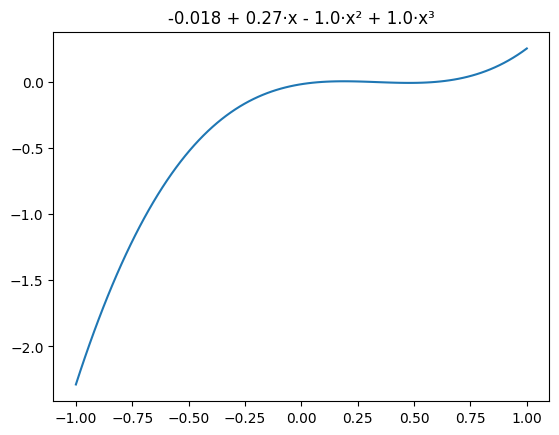

In [25]:
from numpy.polynomial import Polynomial

degree = 3
# construit un polynôme à partir de ses rac:ines pour mieux contrôler son apparence
if degree == 3:
    roots = [0.1, 0.3, 0.6]
elif degree == 2:
    roots = [0.1, 0.6]
elif degree == 1:
    roots = [0.1]
else:
    raise Exception('Degré polynomial non prévu')

P = Polynomial.fromroots(roots)

# affichage
nb_pts = 100
x0,y0 = P.linspace(nb_pts)      # génère les points à afficher (par défaut 100)
plt.plot(x0,y0)
plt.title(f'{P:unicode}')
plt.show()

In [26]:
# visualisation de quelques valeurs dans une table

x, y = P.linspace(5)
x = np.hstack(('x',x))
y = np.hstack(('y',y))

from tabulate import tabulate
print(tabulate([x, y], tablefmt='rounded_grid'))

╭───┬────────┬────────┬────────┬────────┬───────╮
│ x │ -1     │ -0.5   │  0     │  0.5   │ 1     │
├───┼────────┼────────┼────────┼────────┼───────┤
│ y │ -2.288 │ -0.528 │ -0.018 │ -0.008 │ 0.252 │
╰───┴────────┴────────┴────────┴────────┴───────╯


## Floutage de la courbe

Je rajoute maintenant du bruit pour flouter cette courbe avec une distribution [normale](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal).

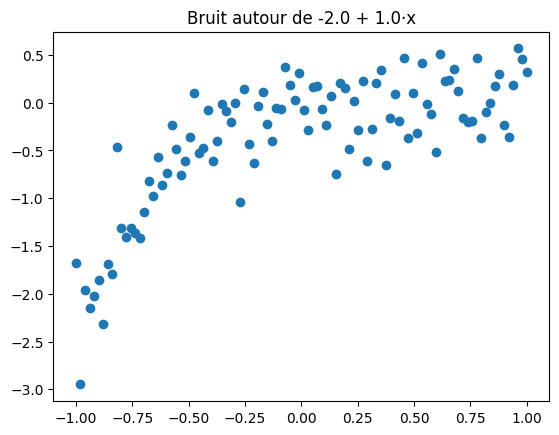

In [27]:
rng = np.random.default_rng(3)

xf = x0
# coef = 20   # ajuste le désordre autour de la référence
coef = 0.3
yf = y0 + rng.normal(scale = coef, size = nb_pts)

plt.scatter(xf,yf)
plt.title(f'Bruit autour de {P0:unicode}')
plt.show()

## Prémière régression avec la méthode '`fit`' de l'objet '`Polynomial`'

Nous recherchons maintenant le polynôme de degré 3 s'adaptant au mieux à ces points. 

Tout d'abord, nous commençons par utiliser la méthode [fit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html) prévue par Numpy.

In [28]:
# trouve le polynôme adapté au nuage de points (méthode des moindres carrés intégrée à NumPy)

P1 = P.fit(xf,yf, deg=degree)
x1,y1 = P1.linspace(nb_pts)

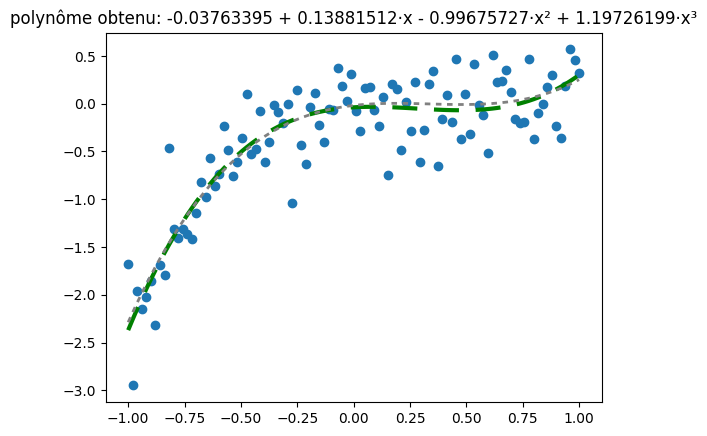

In [29]:
# Affiche les résultats

plt.plot(x1,y1, linewidth=3, color='green', dashes=[6,4])  # le résultat de l'estimation
plt.plot(x0,y0, linewidth=2, color='gray', dashes=[2,2])   # le polynôme d'origine
plt.scatter(xf,yf)                                           # le nuage de points


plt.title(f'polynôme obtenu: {P1:unicode}')
plt.show()

On fera bien attention au comportement particulier de l'objet Polynomial comme décrit dans le [cahier dédié au sujet](../02_std_ext/15_polynomial.ipynb). En particulier, cette démonstration fonctionne ici car le domaine a été conservé entre -1 et 1. En science des données, il est toujours recommandé de normaliser ses entrées avant de commencer.

## Reconstruction de la méthode des moindres carrés

Nous ré-écrivons ici la méthode de moindres carrés, qui est en fait déjà utilisée par Numpy dans la méthode `fit`.

Il faut trouver le paramètre $\theta$ qui annule le gradient de la fonction coût. Nous avions vu l'expression de ce gradient dans le [cahier d'introduction](./00_concepts.ipynb).

$$ \frac{\partial{J}(\theta)}{\partial{\theta}} = \frac{1}{m} X^T \times (X\times\theta -  Y)$$

Il faut donc résoudre.

$$\begin{align*}
&X^T (X \theta -  Y) = [0] \quad \text{\it où $[0]$ est la matrice nulle}\\
&X^T X \,\theta =  X^T Y \\
\end{align*}$$

Quand $X^T\times X$ est inversible (les lignes et les colonnes doivent être réellement indépendantes).

$$ \theta = (X^T\times X)^{-1}\times X^T \times Y$$

In [30]:
# préparation des données

L  = len(xf)
X = xf.reshape(L, 1)
Y = yf.reshape(L, 1)

if degree == 3:
    X = np.hstack((np.ones(L).reshape(L,1), X, X**2, X**3))
elif degree == 2:
    X = np.hstack((np.ones(L).reshape(L,1), X, X**2))
elif degree == 1:
    X = np.hstack((np.ones(L).reshape(L,1), X))
else:
    raise Exception('Degré polynomial non prévu')

print(X.shape, Y.shape, X[2,:])

(100, 4) (100, 1) [ 1.         -0.95959596  0.92082441 -0.88361938]


On applique la formule

$$ \theta = (X^T\times X)^{-1}\times X^T \times Y$$


In [31]:
from numpy.linalg import inv

XT = X.T
XTX = XT @ X
XTX_1= inv(XTX)

XTY = XT @ Y
theta = XTX_1 @ XTY
theta = list(theta.ravel())   # reconvertir en liste simple
theta

# theta.reverse()
P2 = Polynomial(theta)
print(f'{P2:unicode}')

# visualisation de quelques valeurs dans une table
x,y = P2.linspace(5)
x = np.hstack(('x',x))
y = np.hstack(('y',y))

from tabulate import tabulate
print(tabulate((x, y), tablefmt='rounded_grid'))

-0.03763395 + 0.13881512·x - 0.99675727·x² + 1.19726199·x³
╭───┬──────────┬───────────┬────────────┬───────────┬──────────╮
│ x │ -1       │ -0.5      │  0         │  0.5      │ 1        │
├───┼──────────┼───────────┼────────────┼───────────┼──────────┤
│ y │ -2.37047 │ -0.505889 │ -0.0376339 │ -0.067758 │ 0.301686 │
╰───┴──────────┴───────────┴────────────┴───────────┴──────────╯


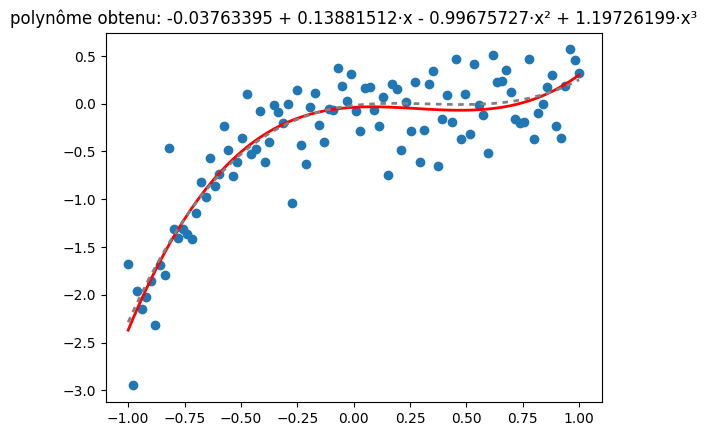

In [32]:
# Affichage des résultats

x2,y2 = P2.linspace(nb_pts)                                # le résultat
plt.plot(x2,y2, linewidth=2, color='red')

plt.plot(x0,y0, linewidth=2, color='gray', dashes=[2,2])   # le polynôme d'origine
plt.scatter(xf,yf)                                         # le nuage de points

plt.title(f'polynôme obtenu: {P2:unicode}')
plt.show()

Sur un exemple simple comme ceux ci, la méthode des moindres carrés peut encore être appliquées. Néanmoins, le coût d'inversion des matrices devient rapidement prohibitif pour des dimensions supérieures.

## Résolution pour la méthode du gradient

Nous reprenons maintenant avec la méthode montré dans le [cahier d'introduction](./00_concepts.ipynb).

In [43]:
L  = len(xf)
X = xf.reshape(L, 1)
Y = yf.reshape(L, 1)

if degree == 3:
    X = np.hstack((np.ones(L).reshape(L,1), X, X**2, X**3))
elif degree == 2:
    X = np.hstack((np.ones(L).reshape(L,1), X, X**2))
elif degree == 1:
    X = np.hstack((np.ones(L).reshape(L,1), X))
else:
    raise Exception('Degré polynomial non prévu')

theta = rng.random(degree+1).reshape(degree+1,1)

print(X.shape, Y.shape, theta.shape, X[2,:])

(100, 4) (100, 1) (4, 1) [ 1.         -0.95959596  0.92082441 -0.88361938]


In [44]:
def model(X, theta):
    return X.dot(theta)

def cost_function(X, y, theta):
    m = y.shape[0]
    return 1 / (2*m) * np.sum(np.square(model(X,theta) -y))

def grad(X,y,theta):
    m = y.shape[0]
    return 1/m * X.T.dot(model(X, theta) -y)

def gradient_descent(X,y,theta, learning_rate, n_iterations):
    cost_history = np.zeros(n_iterations)
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X,y,theta)
        cost_history[i] = cost_function(X,y,theta)
    return theta, cost_history

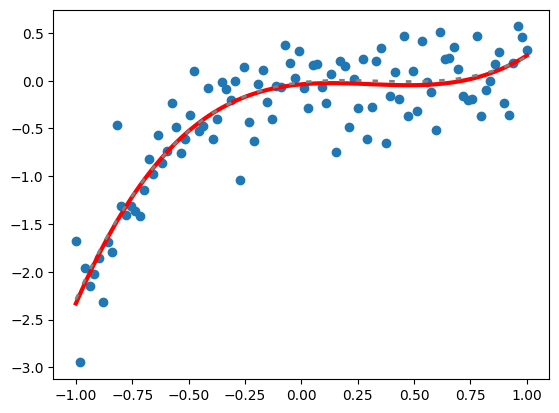

In [65]:
# paramètres fonctionnant pour les deux situations
rate = 0.01
nb_iterations = 10000

theta_final, cost_history = gradient_descent(X,Y,theta, learning_rate=rate, n_iterations=nb_iterations)
prediction = model(X, theta_final)

plt.scatter(xf,yf)  # le nuage de points

plt.plot(xf, prediction, c='r', lw=3)           # les prédictions qui viennent d'être faites
plt.plot(x0, y0, c='gray', lw=2, dashes=[2,4]) # le polynôme d'origine

plt.show()

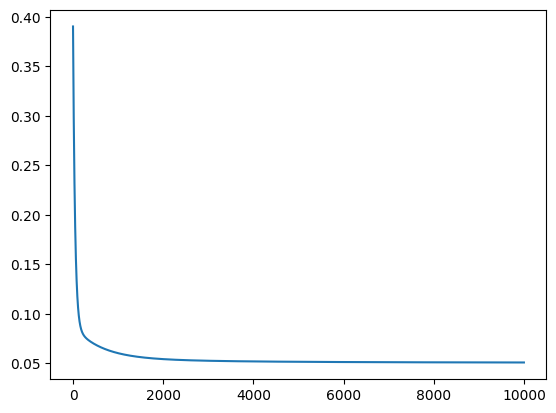

In [66]:
plt.plot(range(0,len(cost_history)), cost_history)

La méthode du gradient fonctionne donc aussi très bien ici.

Dans tous ces exemples, je suis resté avec des valeurs entre -1 et 1, c'est à dire normées. Attention pour les cas non normés, il faut d'abord bien comprendre comment utiliser les [polynômes de Numpy](../02_std_ext/15_polynomial.ipynb).